# Imports:

In [76]:
import lightgbm
import pickle
import pandas as pd
from collections import Counter
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from copy import deepcopy
import seaborn as sns
import shap
from shap import Explainer, Explanation
# import explainerdashboard

In [3]:
from vt_parse import load_family_vt_meta_data

# Data load and transform:

In [10]:
families = [
"7ev3n_vt_metadata.json",
"conti_vt_metadata.jsonl",
"emotet_vt_metadata.jsonl",
"orcus_vt_metadata.jsonl",
"sugar_ransomware_vt_metadata.jsonl",
"cozy_and_veno_vt_metadata.jsonl"
]



df = pd.concat([load_family_vt_meta_data(apt) for apt in families])
len(df)

5100

In [42]:
train_samples_v2 = pd.read_csv("train_samples_v2.csv")
train_samples = pd.read_csv("train_samples.csv")
test_samples_v2 = pd.read_csv("test_samples_v2.csv")
test_samples = pd.read_csv("test_samples.csv")
train_df = df.join(train_samples_v2.rename(columns={"sample_name": "_id"}).set_index("_id"), how="inner")
test_df = df.join(test_samples_v2.rename(columns={"sample_name": "_id"}).set_index("_id"), how="inner")
# train_df = train_df[train_df["family"].notna()]
len(train_df), len(test_df)

(534, 234)

In [40]:
len(train_samples), len(train_samples_v2), len(test_samples), len(test_samples_v2)

(1524, 534, 656, 234)

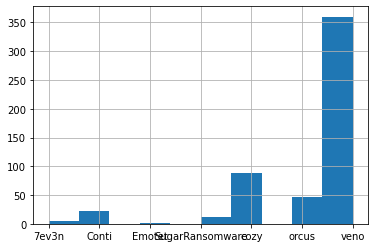

In [95]:
train_df["family"].sort_values().hist()
Counter(train_df["family"])
df.plot(y='number', kind='bar', legend=False)

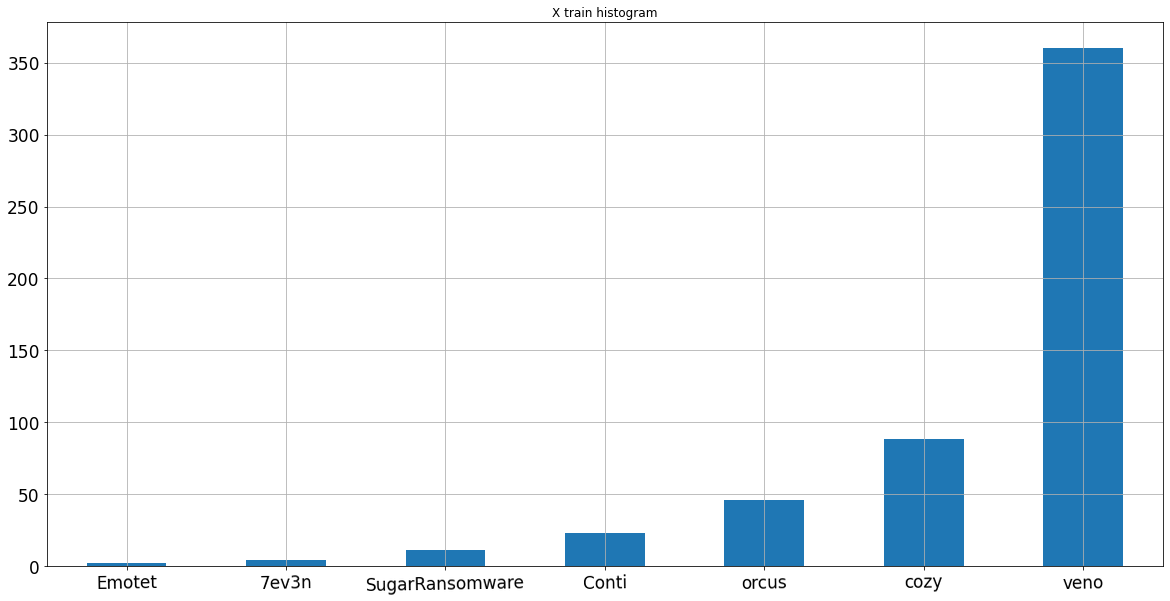

In [108]:
pd.Series(Counter(train_df["family"])).sort_values().plot(kind="bar", rot=1, figsize=(20, 10), fontsize=17, title="X train histogram", grid=True)

In [44]:
Counter(train_df["family"])

Counter({'veno': 360,
         'orcus': 46,
         '7ev3n': 4,
         'Emotet': 2,
         'Conti': 23,
         'cozy': 88,
         'SugarRansomware': 11})

In [48]:
Counter(train_samples["family"])

Counter({'7ev3n': 891,
         'Conti': 104,
         'Emotet': 122,
         'Orcus': 253,
         'SugarRansomware': 154})

In [20]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [63]:
X_train, y_train = train_df.drop(columns=["family"]), train_df["family"].values
X_test, y_test = test_df.drop(columns=["family"]), test_df["family"].values

In [59]:
Counter(y_test)

Counter({'Emotet': 2,
         'cozy': 38,
         'veno': 155,
         'Conti': 10,
         'orcus': 21,
         'SugarRansomware': 6,
         '7ev3n': 2})

In [64]:
X_train.shape, X_test.shape

((534, 19), (234, 19))

# Modeling and plots:

In [65]:
%%time

# from sklearn.linear_model import LogisticRegression
# from sklearn.multiclass import OneVsRestClassifier

# model = LogisticRegression()
# model = OneVsRestClassifier(model)
model = lightgbm.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Wall time: 461 ms


                 precision    recall  f1-score   support

          7ev3n       1.00      1.00      1.00         2
          Conti       0.83      1.00      0.91        10
         Emotet       1.00      1.00      1.00         2
SugarRansomware       1.00      1.00      1.00         6
           cozy       0.88      0.74      0.80        38
          orcus       1.00      0.86      0.92        21
           veno       0.93      0.97      0.95       155

       accuracy                           0.93       234
      macro avg       0.95      0.94      0.94       234
   weighted avg       0.93      0.93      0.93       234



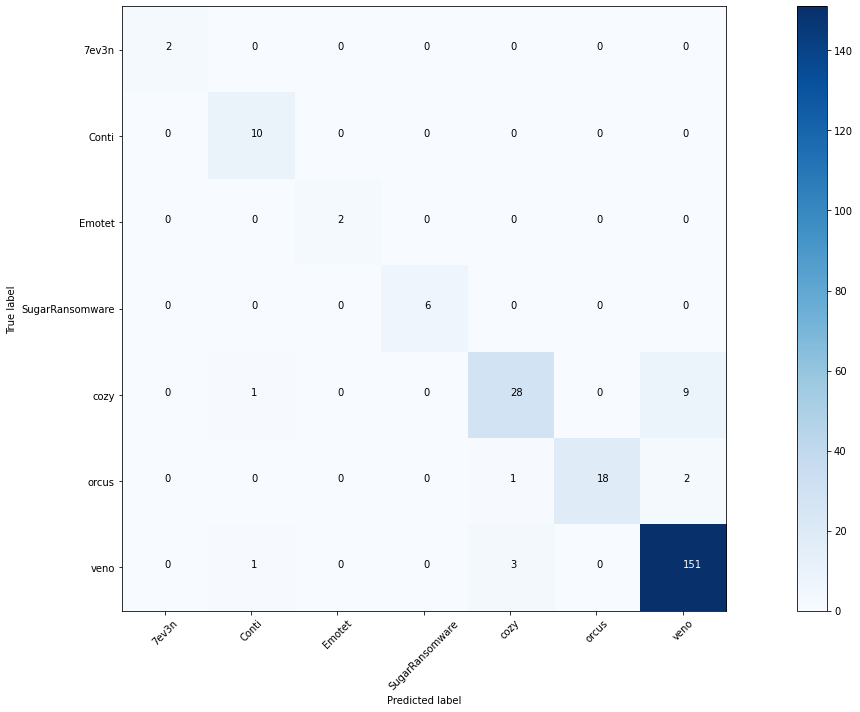

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
labels = np.unique(y_test).tolist()
print(classification_report(y_test, y_pred)) #classification report from sklearn
cnf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
threshold = cnf_matrix.max() / 2 #threshold to define text color
for i in range(cnf_matrix.shape[0]): #print text in grid
    for j in range(cnf_matrix.shape[1]):
        plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.tight_layout()

In [12]:
# vectorizer.get_feature_names()

In [13]:
feature_importances = pd.DataFrame(sorted(zip(model.feature_importances_, vectorizer.get_feature_names())), columns=['Value','Feature']).sort_values(by="Value",ascending=False)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


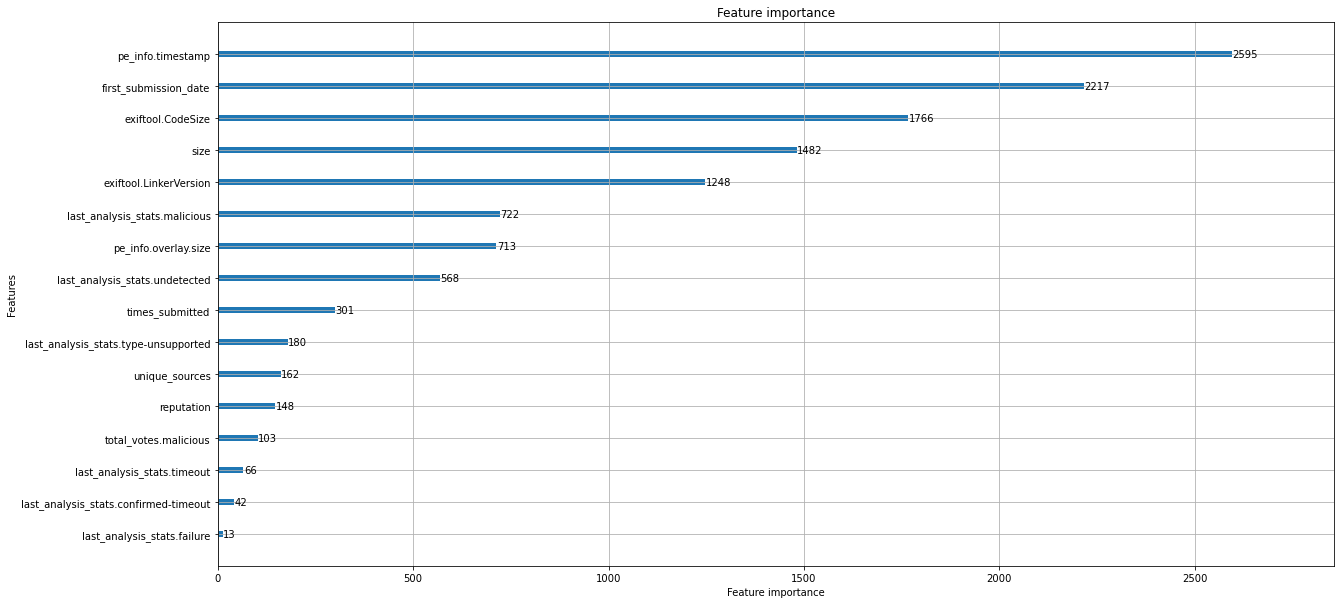

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))
lightgbm.plot_importance(model, max_num_features=20, ax=ax)
plt.show()

# Modeling with feature selection;

In [81]:
%%time
MAX_FEATURES = 250


# train_df, test_df = df[~df["is_test"]], df[df["is_test"]]
# train_df.drop(columns=["is_test"], inplace=True)
# test_df.drop(columns=["is_test"], inplace=True)
# X_train, y_train, X_test, y_test = list(train_df["features"]), list(train_df["family"]), list(test_df["features"]), list(test_df["family"])
# X_temp = deepcopy(X_train)
# vectorizer = DictVectorizer(dtype=np.float64)
# vectorizer.fit(X_temp)
# X_temp = vectorizer.transform(X_temp)
estimator = RandomForestClassifier(10,min_samples_leaf=1,n_jobs=-1)
# MAX_FEATURES = min(len(vectorizer.get_feature_names()), MAX_FEATURES)
selector = SelectFromModel(estimator,max_features=5).fit(X_train, y_train)
support = selector.get_support()
# vectorizer.restrict(support)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [87]:
train_df.isna().sum()

pe_info.timestamp                         15
exiftool.CodeSize                          9
exiftool.LinkerVersion                     9
total_votes.harmless                       0
total_votes.malicious                      0
pe_info.overlay.size                     405
size                                       0
times_submitted                            0
reputation                                 0
unique_sources                             0
first_submission_date                      0
last_analysis_stats.harmless               0
last_analysis_stats.type-unsupported       0
last_analysis_stats.suspicious             0
last_analysis_stats.confirmed-timeout      0
last_analysis_stats.timeout                0
last_analysis_stats.failure                0
last_analysis_stats.malicious              0
last_analysis_stats.undetected             0
family                                     0
dtype: int64

In [18]:
X_train_df = pd.DataFrame(X_train, columns=vectorizer.get_feature_names())
X_test_df = pd.DataFrame(X_test, columns=vectorizer.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [21]:
model = lightgbm.LGBMClassifier(random_state=42)
model.fit(X_train_df, y_train)
y_pred = model.predict(X_test_df)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

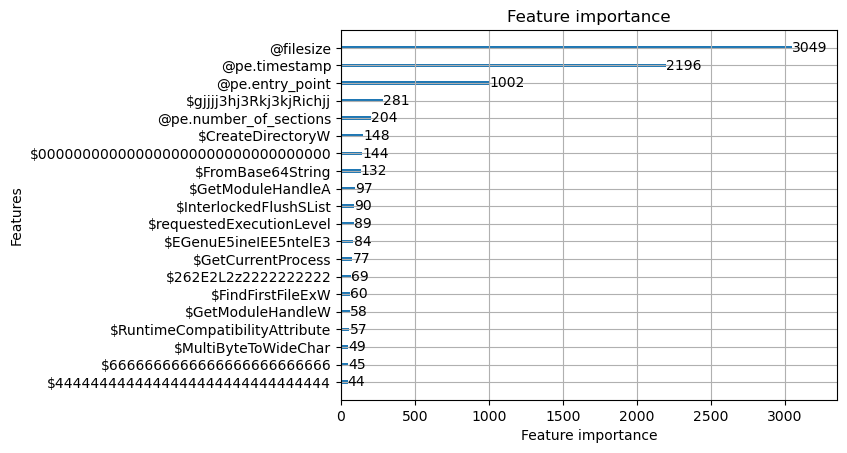

In [22]:
lightgbm.plot_importance(model, max_num_features=20, )

# SHAP:

In [82]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
base_values = np.array(explainer.expected_value)   

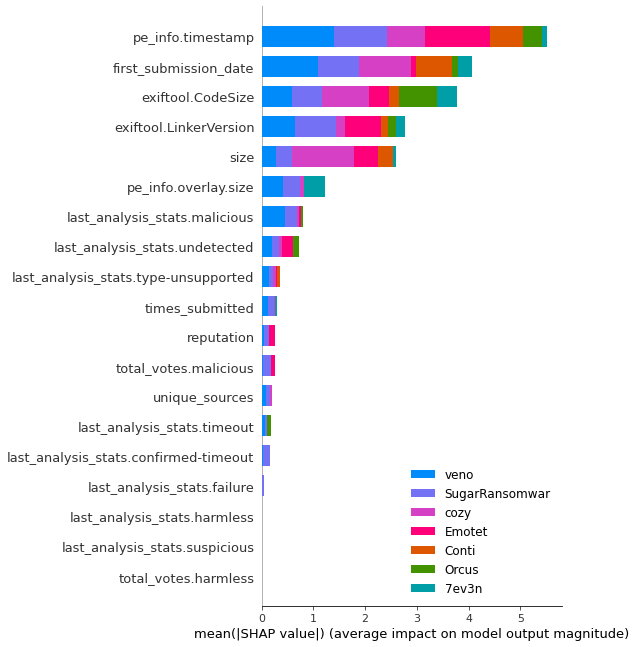

In [84]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=labels, feature_names=X_test.columns)

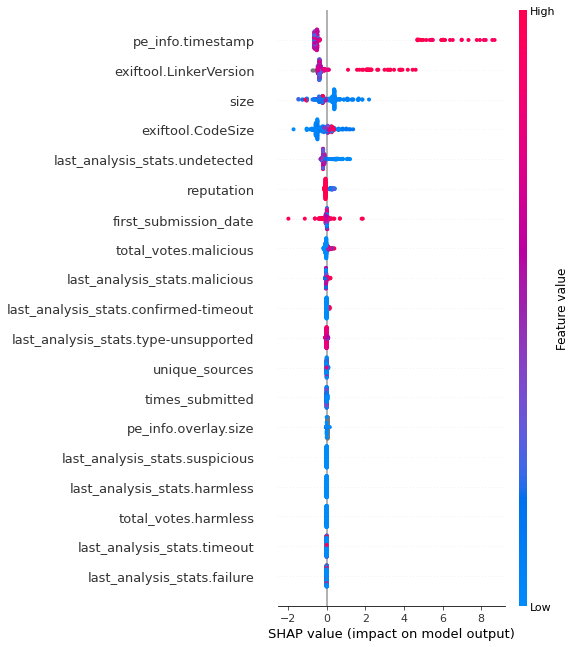

In [85]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)

In [131]:
two_features = train_df[["pe_info.timestamp", "exiftool.LinkerVersion", "family"]][X_train[["pe_info.timestamp", "exiftool.LinkerVersion"]].notna().all(1)]
two_features

,pe_info.timestamp,exiftool.LinkerVersion,family
_id,,,
002286b84fc950d766d0d7826eae96358036b49678a75a719d6773d906167f12,1.196691e+09,6.00,veno
0024d27614933d13f0ba3c380e28558d9470861bcced22ff2be822ec098a8646,1.468915e+09,12.00,orcus
003a903cbab3e91ef22602624645342e81b30ec6263f1e62165abd479c48942e,1.460896e+09,14.00,7ev3n
0041d82cc2a5bb2f447f9c40989292675232cb8404bbfa751c9b961e2f6149c7,1.637003e+09,14.29,Emotet
004ede55a972e10d9a21bcf338b4907d6eed65bf5ad6abbbd5aec7d8484bdedf,1.591229e+09,14.24,Conti
...,...,...,...
880a923211231ad3f375aa58e01a6f41ee9b863fabfe4daf30de88183e20a75e,1.469227e+09,11.00,orcus
88acfde525cba666808caccd4fec7efd76137fda21b857e0d172163498a53b2e,1.510212e+09,12.00,veno
8a2e6027b8c58c35a074bd9cd9619f515248bd8ba5392bd7859a4ba9b1abe369,1.468958e+09,8.00,orcus


In [141]:
two_features

,pe_info.timestamp,exiftool.LinkerVersion,family
_id,,,
002286b84fc950d766d0d7826eae96358036b49678a75a719d6773d906167f12,1.196691e+09,6.00,veno
0024d27614933d13f0ba3c380e28558d9470861bcced22ff2be822ec098a8646,1.468915e+09,12.00,orcus
003a903cbab3e91ef22602624645342e81b30ec6263f1e62165abd479c48942e,1.460896e+09,14.00,7ev3n
0041d82cc2a5bb2f447f9c40989292675232cb8404bbfa751c9b961e2f6149c7,1.637003e+09,14.29,Emotet
004ede55a972e10d9a21bcf338b4907d6eed65bf5ad6abbbd5aec7d8484bdedf,1.591229e+09,14.24,Conti
...,...,...,...
880a923211231ad3f375aa58e01a6f41ee9b863fabfe4daf30de88183e20a75e,1.469227e+09,11.00,orcus
88acfde525cba666808caccd4fec7efd76137fda21b857e0d172163498a53b2e,1.510212e+09,12.00,veno
8a2e6027b8c58c35a074bd9cd9619f515248bd8ba5392bd7859a4ba9b1abe369,1.468958e+09,8.00,orcus


In [144]:
len(list(two_features.groupby("family")))

7

In [147]:
plt.scatter(x=two_features.drop(columns="family").values[:1])

TypeError: scatter() missing 1 required positional argument: 'y'

7ev3n
Conti
Emotet
SugarRansomware
cozy
orcus
veno


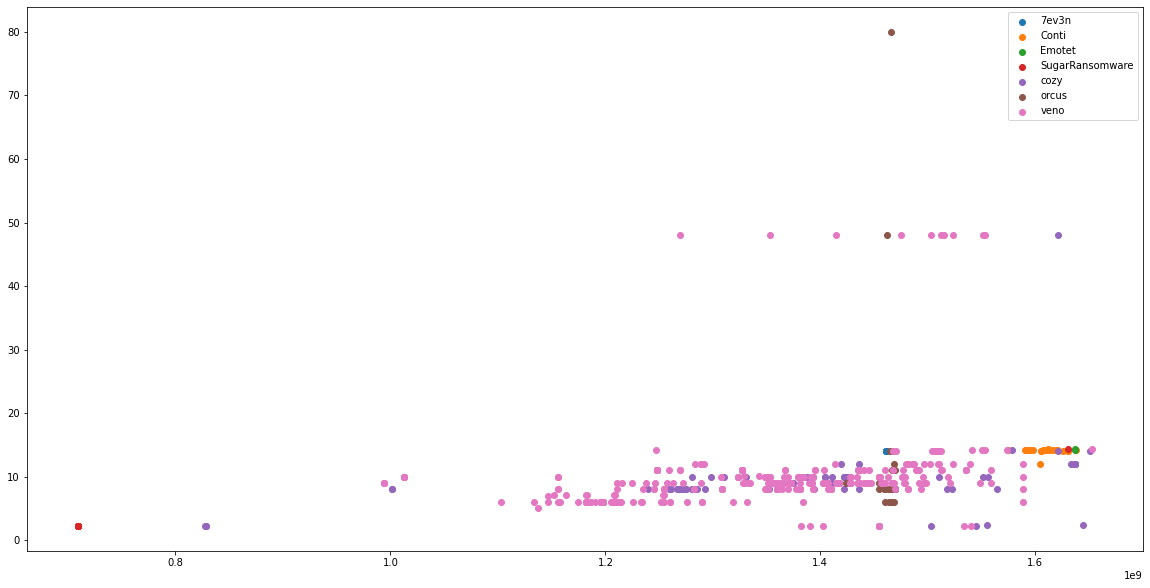

In [162]:
fig, ax = plt.subplots(figsize=(20, 10))
for family, cdf in two_features.groupby("family"):
    print(family)
    plt.scatter(cdf["pe_info.timestamp"], cdf["exiftool.LinkerVersion"], marker='o', label=family)
plt.legend()
plt.show()    

In [86]:
labels, base_values

(['7ev3n', 'Emotet', 'Orcus', 'Conti', 'SugarRansomwar', 'cozy', 'veno'],
 array([-11.09379224,  -9.98413695, -11.45898094, -10.95573317,
         -4.50413299,  -8.94063529,   1.22854726]))

In [171]:
components

array([[ 2.30673976e+08, -1.99789185e+08, -2.51680819e+05, ...,
        -5.01368134e-03, -1.67160037e-17, -8.66773983e-18],
       [-9.03386846e+07, -4.53712743e+07,  7.49469901e+06, ...,
         5.96583474e-03,  6.61228588e-19, -6.88915989e-19],
       [-1.25055888e+08,  1.21232732e+08, -3.05112420e+05, ...,
         6.90893451e-03,  1.29662788e-17,  3.54989635e-18],
       ...,
       [-9.02297123e+07, -4.59459672e+07,  4.64767177e+05, ...,
        -1.39106352e-02, -3.11589567e-18, -6.15306481e-19],
       [-8.48540242e+07, -4.84980283e+07,  6.19806834e+05, ...,
        -1.34108443e-02, -3.98379225e-18, -7.15774268e-19],
       [-9.02590986e+07, -4.59291366e+07,  9.77919046e+05, ...,
        -1.24359901e-02, -3.91010239e-18, -5.71077075e-19]])

In [173]:
!pip show plotly

Name: plotly
Version: 5.6.0
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: c:\users\adirdayan\anaconda3\lib\site-packages
Requires: tenacity, six
Required-by: 


In [176]:
pca.explained_variance_ratio_ * 100

array([7.22077408e+01, 2.77878074e+01, 3.44839626e-03, 7.45195718e-04,
       2.58147533e-04, 2.88809218e-12, 1.15548712e-12, 5.43636999e-13,
       1.14302422e-13, 3.33925890e-14, 2.42150103e-14, 3.86990933e-15,
       1.78571386e-15, 1.00542995e-15, 5.52124330e-16, 2.46838058e-16,
       1.81197339e-17, 1.22660637e-47, 1.31940267e-49])

In [182]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


pca = PCA(n_components=10)
lda = LinearDiscriminantAnalysis(n_components=6)
# components = pca.fit_transform(X_train.fillna(X_train.mean()))
components = lda.fit(X_train.fillna(X_train.mean()), y_train).transform(X_train.fillna(X_train.mean()))
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(lda.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(2),
    color=y_train
)
fig.update_traces(diagonal_visible=False)
fig.write_html('first_figure.html', auto_open=True)
# fig.show()

In [185]:
total_var = lda.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.write_html('first_figure.html', auto_open=True)
# fig.show()

In [62]:
X_test_df.iloc[[i]]

,$000000000000000000000000000000000,$000000011i113333,$060A0F0K0i0s00000000,$1111111116666666666666666,$12171T1y11111111111,$1234567890abcdef,$181G1Z1j1t11111n2u2222222222,$1D1P1T1X1p1t1x11111111111111111X2,$1D1X1t1x111111111111,$1I11111A2I2R2Y222222,...,$wEfsxTPrvekDmfOQGPeAFzwWKIYy,$wProcessorRevision,$wellproxadsit1980,$x00000000000000000,$xROOyaSSygOOxJ55xF,$yyzttuxxywwyuuvttutstzy,@filesize,@pe.entry_point,@pe.number_of_sections,@pe.timestamp
640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,59392.0,6787.0,4.0,1.630778e+09


In [106]:
i = 1 # 650 # 10
label  = y_test[i]
model_prediction = model.predict(X_test_df.iloc[[i]], raw_score=True)[0]
model_prediction_compared_to_base_values = model_prediction - base_values
predicted_label_index = model_prediction_compared_to_base_values.argmax()
predicted_label = labels[predicted_label_index]
"label:", label, "pred:", predicted_label

('label:', '7ev3n', 'pred:', '7ev3n')

In [108]:
X_test_df.iloc[[i]]

,$000000000000000000000000000000000,$000000011i113333,$060A0F0K0i0s00000000,$1111111116666666666666666,$12171T1y11111111111,$1234567890abcdef,$181G1Z1j1t11111n2u2222222222,$1D1P1T1X1p1t1x11111111111111111X2,$1D1X1t1x111111111111,$1I11111A2I2R2Y222222,...,$wEfsxTPrvekDmfOQGPeAFzwWKIYy,$wProcessorRevision,$wellproxadsit1980,$x00000000000000000,$xROOyaSSygOOxJ55xF,$yyzttuxxywwyuuvttutstzy,@filesize,@pe.entry_point,@pe.number_of_sections,@pe.timestamp
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,371826.0,158849.0,6.0,1.460896e+09


In [17]:
H = ppdeep.hash('[C++] VS2013 build 21005 count=50", "[ASM] VS2013 build 21005 count=18", "[ C ] VS2013 build 21005 count=120", "[IMP] VS2008 SP1 build 30729 count=7", "[---] Unmarked objects count=99", "[C++] VS2013 UPD5 build 40629 count=1", "[RES] VS2013 build 21005 count=1", "[LNK] VS2013 UPD5 build 40629 count=1')
h = ppdeep.hash('[ASM] VS2008 SP1 build 30729 count=27", "[ C ] VS2008 SP1 build 30729 count=144", "[IMP] VS2008 SP1 build 30729 count=3", "[---] Unmarked objects count=249", "[C++] VS2008 SP1 build 30729 count=106", "[EXP] VS2008 SP1 build 30729 count=1", "id: 148, version: 30729 count=1", "[LNK] VS2008 SP1 build 30729 count=1')

print(h, H)
ppdeep.compare(h, H)



6:bIk81sbR64+1sbR5CU/1sbR7AAAFJeF/1sbR53b1A1sbR5TAUymAyR5TT81sbR5n:b786+akAAAFJCM2eAUTT8m 6:UsEtL74Fk/AzFar4lA93/1sbR/TsAAjc4F9F8KeR5T0O2lATT2F8KeR5n:q77KFacSvgTsAAga8KUfbTu8Kk


0